In [1113]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw
import imutils
import supervisely as sly

In [1114]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.backends.cudnn.version())   



True
NVIDIA GeForce RTX 3050 Laptop GPU
11.8
90100


In [1115]:
import torch

print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
  print(f'Device {i} name:', torch.cuda.get_device_name(i))

CUDA available True
CUDA version 11.8
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce RTX 3050 Laptop GPU


# Load Model

In [1116]:
import pathlib
from ultralytics import YOLO

# Định nghĩa đường dẫn đến mô hình và ảnh
model_path = "D:\\HK5\\CS406\\TestQR3\\exportmodel\\best2.pt"
# image_path = pathlib.Path("D:\\Data_QR\\data\\qr_2039.jpg")
image_path = pathlib.Path("D:\HK5\CS406\dataqr\\train\images\\4823426566_jpg.rf.4002d6404a1020cb7c9461585a58dbd8.jpg")
# Tải mô hình
model = YOLO(model_path)

# Dự đoán trên ảnh với các tùy chọn bổ sung
result = model.predict(source=image_path , conf=0.6, save=True, device='cpu')



image 1/1 D:\HK5\CS406\dataqr\train\images\4823426566_jpg.rf.4002d6404a1020cb7c9461585a58dbd8.jpg: 544x640 1 qr, 140.8ms
Speed: 2.5ms preprocess, 140.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs\detect\predict176


# Display Predict Image

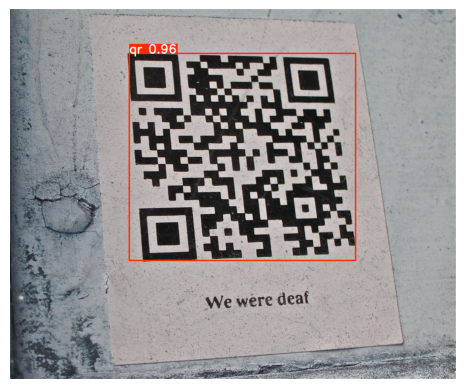

In [1117]:
# Hiển thị ảnh (tùy chọn)
img_with_boxes = result[0].plot()
plt.imshow(img_with_boxes)
plt.axis('off')  # Ẩn trục
plt.show()  # Hiển thị ảnh

# Crop Image

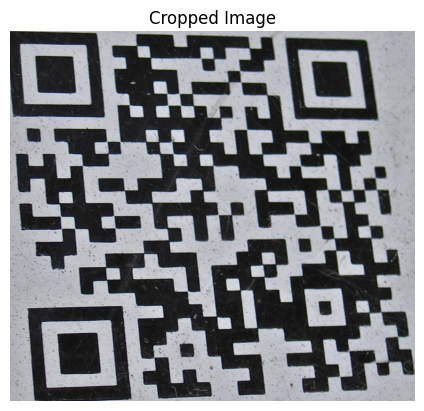

In [1118]:
# Đọc ảnh gốc
image = cv2.imread(str(image_path))

# Khởi tạo biến image_crop
image_crop = image

# Lấy bounding box có độ tin cậy cao nhất
for idx, result in enumerate(result):
    if len(result.boxes) > 0:
        # Sắp xếp các box theo độ tin cậy từ cao đến thấp và lấy box đầu tiên
        best_box = sorted(result.boxes, key=lambda box: box.conf[0], reverse=True)[0]
        x_min, y_min, x_max, y_max = map(int, best_box.xyxy[0])  # Lấy tọa độ dạng int

        # Cắt ảnh trong bounding box
        image_crop = image[y_min:y_max, x_min:x_max]
        image_crop = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        # Hiển thị hình ảnh đã cắt
        plt.imshow(image_crop)  # Chuyển đổi màu BGR sang RGB
        plt.axis('off')  # Ẩn trục
        plt.title('Cropped Image')  # Tiêu đề cho hình ảnh
        plt.show()  # Hiển thị cửa sổ
    else:
        print(f"Image {idx + 1}: No bounding box detected.")

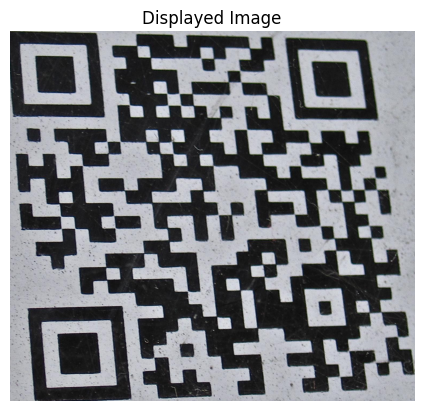

In [1119]:
# Hiển thị hình ảnh
plt.imshow(image_crop)
plt.axis('off')  # Ẩn trục
plt.title('Displayed Image')  # Tiêu đề cho hình ảnh
plt.show()  # Hiển thị cửa sổ

<class 'numpy.ndarray'>


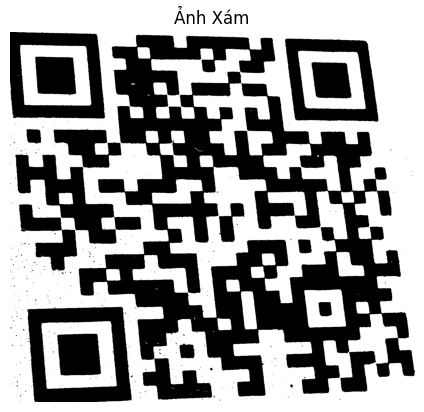

(1378, 1507, 3)


In [1120]:
bgr_image =  cv2.cvtColor(image_crop, cv2.COLOR_RGB2BGR)
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
print(type(binary_image))
# Hiển thị hình ảnh
# Hiển thị ảnh xám
plt.imshow(binary_image, cmap='gray')
plt.axis('off')  # Ẩn trục
plt.title('Ảnh Xám')
plt.show()
print(image_crop.shape)

In [1121]:
print(binary_image)

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [1122]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [1123]:
def is_valid_contour(approx, max_distance):
    # Check distances between consecutive points in the approximated contour
    for i in range(len(approx)):
        p1 = approx[i][0]
        p2 = approx[(i + 1) % len(approx)][0]
        distance = np.linalg.norm(p1 - p2)
        if distance > max_distance:
            return False
    return True

In [1124]:
def is_connected(c1, c2, threshold=20):
    """Kiểm tra xem hai contour có liên thông hay không dựa trên khoảng cách tối đa cho phép."""
    for point1 in c1:
        for point2 in c2:
            if np.linalg.norm(point1 - point2) < threshold:
                return True
    return False

In [1125]:

# check_ptr = strtobool(os.environ["modal.state.ptr"])

# if check_ptr is True:
#     opt_outputMode = "new-project"
# else:
#     opt_outputMode = os.environ["modal.state.outputMode"]
check_ptr = True

In [1126]:
def is_close(p1, p2, threshold=20):
    # Kiểm tra xem hai điểm có gần nhau không
    return np.linalg.norm(p1 - p2) < threshold


In [1127]:
print(type(binary_image))

<class 'numpy.ndarray'>


In [1128]:
def transform(image, local_result_path):
    orig_height, orig_wid = image.shape[:2]
    
    # Chuyển đổi ảnh sang grayscale và làm mịn
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Tạo ảnh nhị phân
    binary_image = np.where(gray < 128, 0, 1).astype(np.uint8)
    edged = cv2.Canny(binary_image * 255, 45, 100)
    
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Vẽ các cạnh lên ảnh gốc
    contour_image = image.copy()
    print(contour_image.shape)
    cv2.drawContours(contour_image, cnts, -1, (0, 255, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Contours')
    plt.show()
# ----------------------------------------------------------------------------------------------------------------------
    # Tìm các contour có liên thông mà không cần khép kín
    boxes = []
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)

        # Kiểm tra nếu có ít nhất 3 điểm (có thể tạo thành box)
        if len(approx) >= 3 and len(approx) <=4 and cv2.contourArea(c) > 1:
            boxes.append(approx)

    # Lấy 5 contour lớn nhất có sự liên thông
    cnts = sorted(boxes, key=cv2.contourArea, reverse=True)[:3]

    # Vẽ các contour đã lọc
    contour_image = image.copy()
    cv2.drawContours(contour_image, cnts, -1, (0, 255, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Filtered Contours')
    plt.show()

    # tìm điểm cuối cùng
    print("R1 : ", cnts[0][0][0],cnts[0][1][0],cnts[0][2][0],cnts[0][3][0])
    print("R2 : ", cnts[1][0][0],cnts[1][1][0],cnts[1][2][0],cnts[1][3][0])
    print("R3 : ", cnts[2][0][0],cnts[2][1][0],cnts[2][2][0],cnts[2][3][0])

    x1,y1 = cnts[0][1][0][0], cnts[0][1][0][1]
    x2, y2 = cnts[1][0][0][0], cnts[1][0][0][1]
    x4, y4 = cnts[2][2][0][0], cnts[2][2][0][1]
    x3 = cnts[1][0][0][0] - cnts[0][1][0][0] + cnts[2][2][0][0]
    y3 = cnts[1][0][0][1] - cnts[0][1][0][1] + cnts[2][2][0][1]
    image_shape = image.shape
    x3 = min(x3, image_shape[0])
    y3 = min(y3, image_shape[1])
    print(image_shape)
    print("R4 : ", x3,y3)

    # # Vẽ điểm (x4, y4) lên ảnh
    # contour_image = image.copy()  # sao chép lại ảnh gốc để vẽ điểm
    # cv2.circle(contour_image, (x4, y4), 10, (0, 0, 255), -1)  # Vẽ một vòng tròn đỏ tại điểm (x4, y4)

    # # Hiển thị ảnh với điểm đã vẽ
    # plt.figure(figsize=(10, 6))
    # plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.title('Point (x4, y4) on Image')
    # plt.show()

    
# -----------------------------------------------------------------------------------------------------------------------

    # Xác định hình chữ nhật từ các contour
    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) >= 3:
            # Kiểm tra nếu có đủ 4 điểm hoặc điều kiện gần nhau
            if len(approx) == 4:
                screenCnt = approx
                break
            elif len(approx) > 4:
                # Kết hợp các điểm gần nhau để tìm ra hình chữ nhật
                merged_points = []
                for point in approx:
                    if not merged_points or not is_close(merged_points[-1][0], point[0]):
                        merged_points.append(point)
                if len(merged_points) == 4:
                    screenCnt = np.array(merged_points)
                    break

    if screenCnt is not None:
        screenCnt = np.array([[x2,y2], [x1,y1], [x4,y4],[x3,y3]])
        pts = np.array(screenCnt.reshape(4, 2), dtype="float32")
        print("PTS : ", pts)
        rect = order_points(pts)

        (tl, tr, br, bl) = rect
        polygon = sly.Polygon(
            exterior=[
                sly.PointLocation(int(tl[0]), int(tl[1])),
                sly.PointLocation(int(tr[0]), int(tr[1])),
                sly.PointLocation(int(br[0]), int(br[1])),
                sly.PointLocation(int(bl[0]), int(bl[1])),
            ]
        )

        # Tính toán chiều rộng và biến đổi phối cảnh
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        # dst = np.array([[0, 0], [widthB, 0], [widthB, widthB], [0, widthB]], dtype="float32")
        orig_height, orig_wid = image.shape[:2]

        # Lấy 4 góc của ảnh
        dst = np.array([[0, 0], [orig_wid, 0], [orig_wid, orig_height], [0, orig_height]], dtype="float32")

        print("Orig : ", orig_wid,orig_height)
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(src=image, M=M, dsize=(orig_wid, orig_height))
        print("------------------------------------")
        print(warped.shape)
        plt.imshow(warped)
        plt.axis('off')
        plt.show()

        cv2.imwrite(local_result_path, warped)
    else:
        print("Không tìm thấy hình chữ nhật đủ điều kiện.")

    return polygon

(1378, 1507, 3)


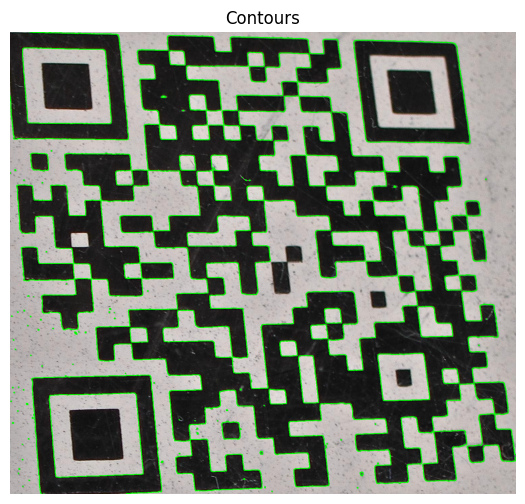

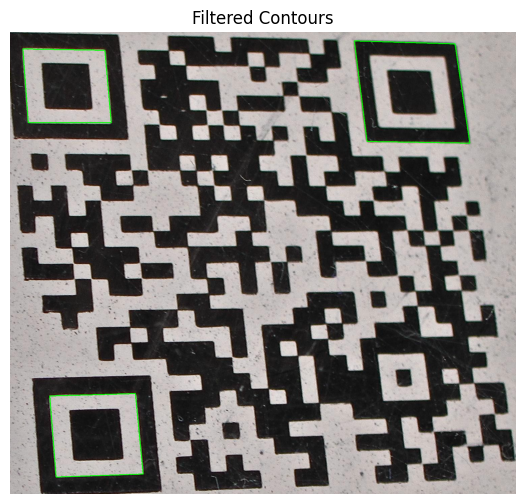

R1 :  [1025   26] [1063  326] [1369  331] [1325   35]
R2 :  [ 373 1078] [ 118 1085] [ 137 1327] [ 396 1318]
R3 :  [38 50] [ 54 270] [301 270] [282  54]
(1378, 1507, 3)
R4 :  -389 1022
PTS :  [[        373        1078]
 [       1063         326]
 [        301         270]
 [       -389        1022]]
Orig :  1507 1378
------------------------------------
(1378, 1507, 3)


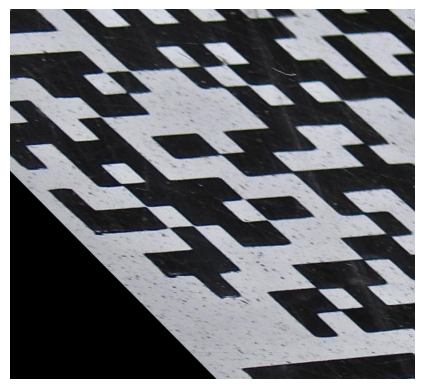

In [1129]:
IMAGE_RESULT_PATH = "D:\HK5\CS406\TestQR3\transform_output"
output_result = transform(image_crop, IMAGE_RESULT_PATH)

In [1130]:
print(output_result)

In [1131]:
print("Polygon points:")
list_point = []
for point in output_result.exterior:
    list_point.append([point.row, point.col])
list_point = np.array(list_point)

Polygon points:


In [1]:
import cv2
from pyzbar.pyzbar import decode
from PIL import Image

# Đọc ảnh dưới dạng màu (thay vì grayscale)
image = cv2.imread("D:\Data_QR\data\qr_309.jpg")

# Giải mã mã QR trong ảnh
barcodes = decode(image)
print(barcodes)

# Vẽ hình chữ nhật quanh mã QR và in nội dung mã QR lên ảnh
for barcode in barcodes:
    # Tọa độ của mã QR
    x, y, w, h = barcode.rect
    # Vẽ hình chữ nhật bao quanh mã QR
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Lấy nội dung của mã QR
    barcode_data = barcode.data.decode("utf-8")
    # Thêm nội dung mã QR lên ảnh
    cv2.putText(image, barcode_data, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Chuyển ảnh từ BGR (OpenCV) sang RGB (Pillow)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Hiển thị ảnh
image_pil.show()

[Decoded(data=b'Courage is being scared to death but saddling up anyway. (John Wayne)', type='QRCODE', rect=Rect(left=81, top=24, width=347, height=344), polygon=[Point(x=81, y=157), Point(x=215, y=368), Point(x=428, y=226), Point(x=288, y=24)], quality=1, orientation='LEFT')]


In [1133]:
# import pathlib
# import random
# import torch
# import matplotlib.pyplot as plt
# from ultralytics import YOLO

# # Đường dẫn tới thư mục ảnh
# folder_path = pathlib.Path("D:/Data_QR/data/")
# # Lấy danh sách tất cả các file ảnh trong thư mục
# image_paths = list(folder_path.glob("*.[jp][pn]g"))


# # Kiểm tra xem số lượng ảnh có đủ để chọn 100 ảnh ngẫu nhiên
# if len(image_paths) < 15:
#     print("Không có đủ 100 ảnh trong thư mục")
# else:
#     # Chọn ngẫu nhiên 100 ảnh từ danh sách
#     random_images = random.sample(image_paths, 100)

#     # Tải mô hình YOLO
#     model_path = "D:\\HK5\\CS406\\TestQR3\\exportmodel\\best2.pt"
#     model = YOLO(model_path)

#     # Lặp qua từng ảnh, dự đoán và hiển thị kết quả
#     for image_path in random_images:
#         # Dự đoán trên ảnh
#         result = model.predict(source=image_path, conf=0.6, device='cpu')
        
#         # Hiển thị ảnh với bounding box
#         img_with_boxes = result[0].plot()  # Thêm các hộp dự đoán lên ảnh
#         plt.imshow(img_with_boxes)
#         plt.axis('off')  # Ẩn trục
#         plt.show()  # Hiển thị ảnh

In [1134]:
# from ultralytics import YOLO

# model_path = "D:\\HK5\\CS406\\TestQR3\\exportmodel\\best2.pt"
# model = YOLO(model_path)

# # Export mô hình sang định dạng TensorFlow (SavedModel)
# model.export(format='saved_model')
